### 1. Data Collection

In [74]:
import json
import pandas as pd

In [75]:
# Digital Music data (64,706) downloaded from: http://jmcauley.ucsd.edu/data/amazon/ 
json_objs = []
with open("Digital_Music_5.json", "r") as f:
    for json_obj in f:
        json_objs.append(json.loads(json_obj))

In [76]:
df = pd.DataFrame(json_objs)
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A3EBHHCZO6V2A4,5555991584,"Amaranth ""music fan""","[3, 3]","It's hard to believe ""Memory of Trees"" came ou...",5.0,Enya's last great album,1158019200,"09 12, 2006"
1,AZPWAXJG9OJXV,5555991584,bethtexas,"[0, 0]","A clasically-styled and introverted album, Mem...",5.0,Enya at her most elegant,991526400,"06 3, 2001"
2,A38IRL0X2T4DPF,5555991584,bob turnley,"[2, 2]",I never thought Enya would reach the sublime h...,5.0,The best so far,1058140800,"07 14, 2003"
3,A22IK3I6U76GX0,5555991584,Calle,"[1, 1]",This is the third review of an irish album I w...,5.0,Ireland produces good music.,957312000,"05 3, 2000"
4,A1AISPOIIHTHXX,5555991584,"Cloud ""...""","[1, 1]","Enya, despite being a successful recording art...",4.0,4.5; music to dream to,1200528000,"01 17, 2008"


In [77]:
print(df.iloc[1]["reviewText"])

A clasically-styled and introverted album, Memory of Trees is a masterpiece of subtlety.  Many of the songs have an endearing shyness to them - soft piano and a lovely, quiet voice.  But within every introvert is an inferno, and Enya lets that fire explode on a couple of songs that absolutely burst with an expected raw power.If you've never heard Enya before, you might want to start with one of her more popularized works, like Watermark, just to play it safe.  But if you're already a fan, then your collection is not complete without this beautiful work of musical art.


### 2. Data Preprocessing

In [78]:
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import wordnet

In [79]:
stoplist = stopwords.words("english")
lemmatizer = WordNetLemmatizer()
# noun and adjectives
chosen_tags = ["NN", "NNS", "JJ"]

In [80]:
def clean(text):
    # remove punctuation
    nopunc_text = re.sub(r"[!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~]", " ", text)
    # remove everything except alphabetic characters
    alpha_text = re.sub(r"[^A-Za-z]", " ", nopunc_text)
    # eliminate multiple spaces
    nomspace_text = re.sub(r"\s+", " ", alpha_text)
    return nomspace_text

In [81]:
def get_pos_tag(tag):
    if tag.startswith("N") or tag.startswith("J"):
        return wordnet.NOUN
    elif tag.startswith("V"):
        return wordnet.VERB
    elif tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [82]:
def preprocess(text):
    # clean text
    cleaned_text = clean(text)
    lowered_text = cleaned_text.lower()
    
    # tokenization
    tokens = word_tokenize(lowered_text)
    
    # remove stopwords and single character words
    words = [token for token in tokens if token not in stoplist or len(token) > 1]
    
    # lemmatize words
    tagged_words = nltk.pos_tag(words)
    lemmatized_words = [lemmatizer.lemmatize(word, get_pos_tag(tag)) for word, tag in tagged_words if tag in chosen_tags]
    
    return " ".join(lemmatized_words)

In [18]:
df_clean = df["reviewText"].apply(preprocess)

In [19]:
cleaned_review_text = df_clean.values.tolist()

In [20]:
# save the preprocessed text
with open("Cleaned_Digital_Music_LDA.txt", "w") as f:
    f.writelines("\n".join(cleaned_review_text))

In [83]:
# read clean data
with open("Cleaned_Digital_Music_LDA.txt", "r") as f:
    file_data = f.readlines()
data = [d.strip().split() for d in file_data] 

### 3. Topic modeling using LDA

In [84]:
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel
import logging
import time

In [85]:
# logging.basicConfig(format = "%(asctime)s : %(levelname)s : %(message)s", level = logging.DEBUG)

In [86]:
# add bigrams as words like very_nice can appear
def append_bigrams(docs):
    bigram = Phrases(docs, min_count = 10)
    for idx in range(len(docs)):
        for token in bigram[docs[idx]]:
            if "_" in token:
                docs[idx].append(token)
    return docs

In [87]:
docs = append_bigrams(data)

In [88]:
dictionary = Dictionary(docs)
# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below = 20, no_above = 0.5)

In [89]:
corpus = [dictionary.doc2bow(doc) for doc in docs]

In [90]:
print(f"Size of dictionary: {len(dictionary)}")
print(f"Size of corpus: {len(corpus)}")

Size of dictionary: 14239
Size of corpus: 64706


In [91]:
num_topics = 3
chunksize = 10000
passes = 20
iterations = 400
eval_every = None

In [92]:
temp = dictionary[0]
id2word = dictionary.id2token

In [23]:
t0 = time.time()
model = LdaModel(
    corpus = corpus,
    id2word = dictionary.id2token,
    chunksize = chunksize,
    alpha = "auto", # document topic distribution
    eta = "auto", # topic word distribution
    iterations = iterations,
    num_topics = num_topics,
    passes = passes,
    eval_every = eval_every
)
t1 = time.time()
print(f"Time take to train the model: {(t1 - t0)/60}m")

Time take to train the model: 7.977274986108144m


### 5. Save and load model

In [36]:
import os
import time

dir_path = f"models/ldamodel_{num_topics}t_{passes}p_{iterations}i_{time.asctime().replace(':', '').replace(' ', '_')}"
os.mkdir(dir_path)
model.save(f"{dir_path}/ldamodel")

In [93]:
lda_model = LdaModel.load(f"models/ldamodel_3t_20p_400i_Tue_Nov__8_180201_2022/ldamodel")
# lda_model = model

### 4. Coherence Score Calculation

In [94]:
from gensim.models.coherencemodel import CoherenceModel

In [95]:
top_topics = lda_model.top_topics(corpus, topn = 10)
avg_topic_coherence = sum(t[1] for t in top_topics)/num_topics
print(f"Average topic coherence {avg_topic_coherence}")

Average topic coherence -6.1238275363228665


In [98]:
from gensim.test.utils import common_corpus, common_dictionary
cm = CoherenceModel(model = lda_model, corpus = common_corpus, dictionary = common_dictionary, coherence = "u_mass")
print(cm.get_coherence())

-1.9263592690963973


In [104]:
ref_docs = docs[50:1000]
ref_dic = Dictionary(ref_docs)
cv_cm = CoherenceModel(model = lda_model, texts = ref_docs, dictionary = ref_dic, coherence = "c_v")
print(cv_cm.get_coherence())

0.5252864259976798


In [105]:
cuci_cm = CoherenceModel(model = lda_model, texts = ref_docs, dictionary = ref_dic, coherence = "c_uci")
print(cuci_cm.get_coherence())

-11.510130743036362


In [106]:
cnpmi_cm = CoherenceModel(model = lda_model, texts = ref_docs, dictionary = ref_dic, coherence = "c_npmi")
print(cnpmi_cm.get_coherence())

-0.40426351896413526


### 6. Find topics of documents

In [33]:
docs = df["reviewText"]
topics = [lda_model.get_document_topics(corpus[i], minimum_probability = 0) for i in range(len(corpus))]
topic_documents_df = pd.DataFrame({"topics_dist": topics, "docs": docs})
topic_documents_df.head()

,topics_dist,docs
0,"[(0, 0.0011573068), (1, 0.48431164), (2, 0.514...","It's hard to believe ""Memory of Trees"" came ou..."
1,"[(0, 0.0023514389), (1, 0.59573454), (2, 0.401...","A clasically-styled and introverted album, Mem..."
2,"[(0, 0.002976133), (1, 0.99303114), (2, 0.0039...",I never thought Enya would reach the sublime h...
3,"[(0, 0.0021972412), (1, 0.6404592), (2, 0.3573...",This is the third review of an irish album I w...
4,"[(0, 0.00032000977), (1, 0.44789845), (2, 0.55...","Enya, despite being a successful recording art..."


In [34]:
for i in range(10):
    topic_dist = lda_model.get_document_topics(corpus[i], minimum_probability = 0)
    print(f"Document Index: {i}, Topic Districution: {topic_dist}")

Document Index: 0, Topic Districution: [(0, 0.0011573057), (1, 0.48530018), (2, 0.51354253)]
Document Index: 1, Topic Districution: [(0, 0.0023514389), (1, 0.59576446), (2, 0.40188408)]
Document Index: 2, Topic Districution: [(0, 0.002976133), (1, 0.99303114), (2, 0.003992762)]
Document Index: 3, Topic Districution: [(0, 0.0021972416), (1, 0.6404515), (2, 0.3573513)]
Document Index: 4, Topic Districution: [(0, 0.00032000963), (1, 0.4479937), (2, 0.5516863)]
Document Index: 5, Topic Districution: [(0, 0.053434312), (1, 0.79137105), (2, 0.15519463)]
Document Index: 6, Topic Districution: [(0, 0.00054259197), (1, 0.74397504), (2, 0.25548238)]
Document Index: 7, Topic Districution: [(0, 0.00022776992), (1, 0.73195326), (2, 0.26781893)]
Document Index: 8, Topic Districution: [(0, 0.0021920365), (1, 0.84715307), (2, 0.15065485)]
Document Index: 9, Topic Districution: [(0, 0.00063632685), (1, 0.5855769), (2, 0.4137868)]


In [35]:
topic_dist = lda_model.get_document_topics(corpus[0], minimum_probability = 0, per_word_topics = True)
print("Document Index: 0")
print("\nTopic distribution for whole document:")
print(topic_dist[0])
print("\nMost probable topics per word:")
print(topic_dist[1])
# a word’s id and a list of the phi values between this word and each topic with phi values multiplied by the feature length (i.e. word count)
print("\nWord-topic combination with phi relevance value:")
print(topic_dist[2])

Document Index: 0

Topic distribution for whole document:
[(0, 0.0011573067), (1, 0.48429373), (2, 0.51454896)]

Most probable topics per word:
[(0, [2, 1]), (1, [2, 1]), (2, [2, 1]), (3, [1, 2]), (4, [2, 1]), (5, [2, 1]), (6, [1, 2]), (7, [1, 2]), (8, [1, 2]), (9, [2, 1]), (10, [1, 2]), (11, [2, 1]), (12, [2, 1]), (13, [1, 2]), (14, [2, 1]), (15, [1, 2]), (16, [1, 2]), (17, [2, 1]), (18, [2, 1]), (19, [1, 2]), (20, [2, 1]), (21, [1, 2]), (22, [2, 1]), (23, [1, 2]), (24, [2, 1]), (25, [2, 1]), (26, [2, 1]), (27, [2, 1]), (28, [1, 2]), (29, [2]), (30, [2, 1]), (31, [2, 1]), (32, [2, 1]), (33, [1, 2]), (34, [1, 2]), (35, [1, 2]), (36, [1, 2]), (37, [2, 1]), (38, [2, 1]), (39, [1, 2]), (40, [1, 2]), (41, [2, 1]), (42, [1, 2]), (43, [2, 1]), (44, [2, 1]), (45, [2, 1]), (46, [2, 1]), (47, [1, 2]), (48, [1, 2]), (49, [1, 2]), (50, [2, 1])]

Word-topic combination with phi relevance value:
[(0, [(1, 0.85591334), (2, 1.1440125)]), (1, [(1, 0.4863714), (2, 0.5133308)]), (2, [(1, 0.47733024), (2

### 7. Find words distribution in the topics

In [37]:
# Get the representation of all topics
topics = lda_model.print_topics(num_topics = 3, num_words = 5)
for topic in topics:
    print(f"Topic {topic[0]} \nTop Word Distribution: {topic[1]}\n")

Topic 0 
Top Word Distribution: 0.015*"he" + 0.013*"his" + 0.010*"get" + 0.009*"track" + 0.009*"good"

Topic 1 
Top Word Distribution: 0.009*"a" + 0.008*"their" + 0.007*"sound" + 0.007*"they" + 0.007*"not"

Topic 2 
Top Word Distribution: 0.030*"quot" + 0.016*"her" + 0.011*"she" + 0.008*"a" + 0.008*"love"



In [38]:
# Get the representation for a single topic
lda_model.show_topic(0)

[('he', 0.015089577),
 ('his', 0.012811045),
 ('get', 0.009595751),
 ('track', 0.009146381),
 ('good', 0.009031484),
 ('not', 0.0079036085),
 ('all', 0.0075429105),
 ('do', 0.007374793),
 ('beat', 0.007287922),
 ('cd', 0.0071698613)]

In [39]:
# Get the topics with the highest coherence score
top_topics = lda_model.top_topics(corpus, topn = 10)
for i in range(len(top_topics)):
    print(f"Topic {i} \nTop Word Distribution: {top_topics[i]}\n")

Topic 0 
Top Word Distribution: ([(0.009443973, 'a'), (0.0075307507, 'their'), (0.007476736, 'sound'), (0.0074265436, 'they'), (0.0071240724, 'not'), (0.0070446124, 'band'), (0.006453608, 'from'), (0.005988531, 'more'), (0.005919484, 'all'), (0.005858845, 'track')], -4.561283221228842)

Topic 1 
Top Word Distribution: ([(0.029985553, 'quot'), (0.015821168, 'her'), (0.011163123, 'she'), (0.008199727, 'a'), (0.00778771, 'love'), (0.007052672, 'my'), (0.0068984376, 'music'), (0.0068946294, 'not'), (0.00678016, 'from'), (0.006508428, 'all')], -5.494603429473942)

Topic 2 
Top Word Distribution: ([(0.015089577, 'he'), (0.012811045, 'his'), (0.009595751, 'get'), (0.009146381, 'track'), (0.009031484, 'good'), (0.0079036085, 'not'), (0.0075429105, 'all'), (0.007374793, 'do'), (0.007287922, 'beat'), (0.0071698613, 'cd')], -8.315595958265812)



### 8. Visualization

In [41]:
import pyLDAvis
import pyLDAvis.gensim_models

/home/fm-pc-lt-151/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [44]:
pyLDAvis.enable_notebook()
# vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, mds = "mmds", R = 30)
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

/home/fm-pc-lt-151/anaconda3/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/home/fm-pc-lt-151/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fm-pc-lt-151/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fm-pc-lt-151/anaconda3/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/home/fm-pc-lt-151/anaconda3/lib/

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.075670 -0.080468       1        1  47.334944
2     -0.084292  0.077628       2        1  26.737746
0      0.159962  0.002840       3        1  25.927310, topic_info=       Term          Freq         Total Category  logprob  loglift
294    quot  64780.000000  64780.000000  Default  30.0000  30.0000
113    beat  17199.000000  17199.000000  Default  29.0000  29.0000
335      cd  40828.000000  40828.000000  Default  28.0000  28.0000
2191    rap   8359.000000   8359.000000  Default  27.0000  27.0000
3937    hop   7241.000000   7241.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
313   thing   4060.254742  15272.448195   Topic3  -5.6358   0.0251
884     don   3925.395049  12131.317960   Topic3  -5.6695   0.2215
23    music   4476.591244  44957.498743   Topic3  -5.5381  -0.9570
50     year   4131.377413  21531.069661   Topic3  -5.6184  -0.3010
24      new   3941.654074  22212.766025   Topic3  -5.6654  -0.3792

[274 rows x 6 columns], token_table=       Topic      Freq             Term
term                                   
1541       1  0.992285       accessible
1541       2  0.007323       accessible
3345       1  0.890739         acoustic
3345       2  0.109116         acoustic
3346       1  0.988583  acoustic_guitar
...      ...       ...              ...
50         1  0.437972             year
50         2  0.370163             year
50         3  0.191862             year
12729      1  0.998854            yorke
4689       3  0.999562                z

[424 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])

### 9. Find topic distribution of new document

In [45]:
from collections import defaultdict

In [46]:
def get_bow(words, dic):
    # count the frequency of words
    word_by_freq = defaultdict(int)
    for val in words:
        word_by_freq[val] += 1

    # get the index of word from dictionary and create (index, frequency) list
    lst = []
    for word, freq in word_by_freq.items():
        idx = [i for i in dic if dic[i] == word]
        if len(idx) == 0:
            continue
        lst.append((idx[0], freq))
    return lst

In [47]:
def sort_by_score(lst):
    lst.sort(key = lambda x: x[1])
    lst.reverse()
    return lst

In [48]:
test_doc = "Canadian punks PUP are probably the loudest band in their lane, at least in terms of live performance. But this new one draws the band away from pummeling guitars and into something more midtempo; the trademark energy and shout-along vocals, however, are still intact."
preprocessed_test_doc = preprocess(test_doc)
bow_test_doc = get_bow(preprocessed_test_doc, lda_model.id2word)
# print(bow_test_doc)

vector = lda_model[bow_test_doc]
# print(vector)
new_vector = sort_by_score(vector)
print(new_vector)

[(1, 0.9889567)]


### 10. Finding optimal number of topics

In [49]:
import matplotlib.pyplot as plt

In [50]:
def compute_coherence_values(dictionary, corpus, limit, start = 2, step = 3):
    model_list = []
    coherence_values = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus = corpus, num_topics = num_topics, id2word = dictionary.id2token)
        model_list.append(model)
        cm = CoherenceModel(model = model, corpus = corpus, coherence = "u_mass")
        coherence_values.append(cm.get_coherence())
        
    return model_list, coherence_values 

In [51]:
model_list, coherence_values = compute_coherence_values(dictionary, corpus, start = 10, limit = 1000, step = 100 )

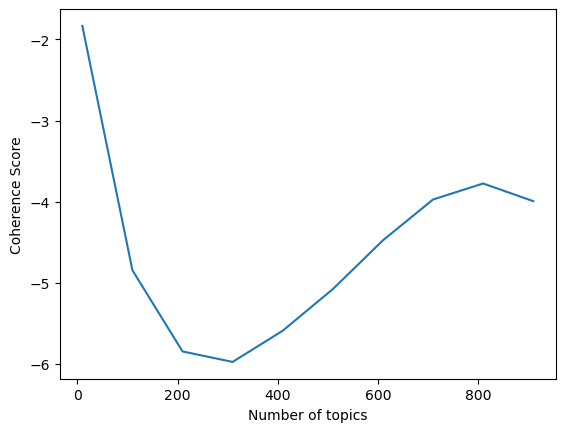

In [52]:
start = 10; limit = 1000; step = 100;
topics = range(start, limit, step)
plt.plot(topics, coherence_values)
plt.xlabel("Number of topics")
plt.ylabel("Coherence Score")
plt.show()

In [53]:
for t, cv in zip(topics, coherence_values):
    print(f"Topic No.: {t} \t Coherence Value: {cv}")

Topic No.: 10 	 Coherence Value: -1.8329485474775218
Topic No.: 110 	 Coherence Value: -4.846574313730761
Topic No.: 210 	 Coherence Value: -5.848037853693292
Topic No.: 310 	 Coherence Value: -5.977377574578201
Topic No.: 410 	 Coherence Value: -5.592302812977476
Topic No.: 510 	 Coherence Value: -5.079237860694058
Topic No.: 610 	 Coherence Value: -4.4777558838709135
Topic No.: 710 	 Coherence Value: -3.973998713989967
Topic No.: 810 	 Coherence Value: -3.7765899152844167
Topic No.: 910 	 Coherence Value: -3.9943384525304158


### 11. Finding dominant topic for each text

In [54]:
def format_topic_text(model, corpus, docs):
    topics_df = pd.DataFrame()
    
    for i, row in enumerate(model[corpus]):
        topics_dsc = sorted(row, key = lambda x: x[1], reverse = True)
        
        # get main topic and its proportion and words
        top_topic_num, top_topic_prop = topics_dsc[0][0], topics_dsc[0][1]
        top_topic_words = [word for word, prop in model.show_topic(top_topic_num)]
        
        topics_df = topics_df.append(pd.Series([int(top_topic_num), round(top_topic_prop, 4), top_topic_words]), ignore_index = True)
    
    topics_df.columns = ["Dominant_Topic", "Topic_Proportion", "Topic_Words"]
    contents = pd.Series(docs)
    docs_topics_df = pd.concat([contents, topics_df], axis = 1)
    
    return docs_topics_df

In [55]:
docs_df = format_topic_text(model, corpus, df["reviewText"])

/tmp/ipykernel_24979/121416463.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(pd.Series([int(top_topic_num), round(top_topic_prop, 4), top_topic_words]), ignore_index = True)
/tmp/ipykernel_24979/121416463.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  topics_df = topics_df.append(pd.Series([int(top_topic_num), round(top_topic_prop, 4), top_topic_words]), ignore_index = True)


In [56]:
docs_df.head()

,reviewText,Dominant_Topic,Topic_Proportion,Topic_Words
0,"It's hard to believe ""Memory of Trees"" came ou...",1,0.9967,"[music, track, band, time, sound, good, great,..."
1,"A clasically-styled and introverted album, Mem...",1,0.9932,"[music, track, band, time, sound, good, great,..."
2,I never thought Enya would reach the sublime h...,1,0.9914,"[music, track, band, time, sound, good, great,..."
3,This is the third review of an irish album I w...,1,0.9937,"[music, track, band, time, sound, good, great,..."
4,"Enya, despite being a successful recording art...",1,0.9991,"[music, track, band, time, sound, good, great,..."


In [57]:
print(docs_df["reviewText"][0])
print()
print(docs_df["Topic_Words"][0])

It's hard to believe "Memory of Trees" came out 11 years ago;it has held up well over the passage of time.It's Enya's last great album before the New Age/pop of "Amarantine" and "Day without rain." Back in 1995,Enya still had her creative spark,her own voice.I agree with the reviewer who said that this is her saddest album;it is melancholy,bittersweet,from the opening title song."Memory of Trees" is elegaic&majestic.;"Pax Deorum" sounds like it is from a Requiem Mass,it is a dark threnody.Unlike the reviewer who said that this has a "disconcerting" blend of spirituality&sensuality;,I don't find it disconcerting at all."Anywhere is" is a hopeful song,looking to possibilities."Hope has a place" is about love,but it is up to the listener to decide if it is romantic,platonic,etc.I've always had a soft spot for this song."On my way home" is a triumphant ending about return.This is truly a masterpiece of New Age music,a must for any Enya fan!

['music', 'track', 'band', 'time', 'sound', 'goo

### 12. Most representative document for each topic

In [58]:
sorted_docs_by_topic = pd.DataFrame()

docs_by_topic = docs_df.groupby(["Dominant_Topic"])
for i, group in docs_by_topic:
    sorted_docs_by_topic = pd.concat([sorted_docs_by_topic, group.sort_values(["Topic_Proportion"], ascending = [0]).head(1)], axis = 0)

In [59]:
sorted_docs_by_topic = pd.DataFrame(sorted_docs_by_topic)
sorted_docs_by_topic.reset_index(drop = True, inplace = True)
sorted_docs_by_topic.head()

,reviewText,Dominant_Topic,Topic_Proportion,Topic_Words
0,I will be the first person to admit that when ...,0,0.9996,"[quot, track, good, cd, beat, great, rap, time..."
1,"Shadows Fall aside, Lamb of God had to be the ...",1,0.9997,"[music, track, band, time, sound, good, great,..."
2,"Once upon a time, Time-Life books released a s...",2,0.9994,"[cd, great, track, music, good, time, hit, ver..."


### 13. Topic distribution across documents

In [61]:
# Number of documents for each topic
topic_counts = docs_df["Dominant_Topic"].value_counts()
print(topic_counts)

1    28836
2    18325
0    17545
Name: Dominant_Topic, dtype: int64


In [62]:
# Percentage of documents for each topic
topic_distribution = round(topic_counts/topic_counts.sum(), 4)
print(topic_distribution)

1    0.4456
2    0.2832
0    0.2711
Name: Dominant_Topic, dtype: float64


### 14. Find topic distribution of short reviews

In [63]:
short_reviews = df[(df["reviewText"].str.len() <= 100) & (df["reviewText"].str.len() >= 80)]
short_reviews.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
324,A2NIQDDCSZD5GI,B0000004UM,"Hillari Hunter ""Westside Tomboy""","[0, 0]",Good album from one of the more prominent old ...,4.0,KRS-One is the Man!,1060819200,"08 14, 2003"
353,A1JBVQQ9Q91BWY,B0000004UU,ladavis1977,"[0, 0]","not bad, still ok too here it again. too- shor...",3.0,old school,1375056000,"07 29, 2013"
472,A1KDEDXOWABBQ6,B00000050N,"C ""mrvillain""","[1, 1]",The whole CD is exactly what it says in the ti...,5.0,super damn tight,1036454400,"11 5, 2002"
498,A461VTLW9G9YB,B00000050T,Dance Dance Dance,"[0, 1]",This is probably R kellys best work to date. I...,5.0,BEST,1073260800,"01 5, 2004"
582,A2CQHOPBQSZX3G,B00000052I,mark shelton,"[0, 0]",i had this cd back in the days and it broke go...,5.0,great cd,1356652800,"12 28, 2012"


In [64]:
short_reviews_index = short_reviews.index.tolist()

In [65]:
short_review_texts = short_reviews["reviewText"].values.tolist()
for t in short_review_texts:
    print(t)
    print()

Good album from one of the more prominent old school rappers, who is still around.

not bad, still ok too here it again. too- short is one of those rappers who never get old. good

The whole CD is exactly what it says in the title Super Tight... 4 real this UGK at its best.

This is probably R kellys best work to date. I still love the songs  from this album.

i had this cd back in the days and it broke got me a new one brings back memories. lovely cd.

i like these cd that  he  has in amazon  we really like his singingand you can to like him

Who can make a CD better than Kells? This is an oldie but as with all of them its a goodie.....

ONE DAY HAS ALWAYS BEEN A FAVORITE OF MINE FROM UGK. I HAD TO REPLACE THIS CD IN MY COLLECTION.

great cd my favorite from ugk. rip pimp c this cd looks better then the original i used to own.

I hate E-40, but I gave this 3 stars cuz that song &quot;Rapper's Ball&quot; is off the hook!

I love this band they get better and better finally a new school

In [66]:
short_reviews_details = list(zip(short_reviews.index, short_reviews["reviewText"].values))
for idx, text in short_reviews_details:
    topic_dist = lda_model.get_document_topics(corpus[idx],)
    print(f"Document Index: {idx} \nReview Text: {text} \nTopic Districution: {topic_dist}\n")

Document Index: 324 
Review Text: Good album from one of the more prominent old school rappers, who is still around. 
Topic Districution: [(0, 0.735864), (1, 0.24849766), (2, 0.015638357)]

Document Index: 353 
Review Text: not bad, still ok too here it again. too- short is one of those rappers who never get old. good 
Topic Districution: [(0, 0.9493632), (1, 0.03209888), (2, 0.01853795)]

Document Index: 472 
Review Text: The whole CD is exactly what it says in the title Super Tight... 4 real this UGK at its best. 
Topic Districution: [(0, 0.96306825), (1, 0.023426432), (2, 0.013505281)]

Document Index: 498 
Review Text: This is probably R kellys best work to date. I still love the songs  from this album. 
Topic Districution: [(0, 0.9489963), (1, 0.03242075), (2, 0.018582953)]

Document Index: 582 
Review Text: i had this cd back in the days and it broke got me a new one brings back memories. lovely cd. 
Topic Districution: [(0, 0.021129575), (1, 0.039516583), (2, 0.9393538)]

Docume